# EDA and Models for Sentiment Analysis

In this notebook we will do some data analysis with the sentiment dataset we put together.
Furthermore we will use some machine learning models to try and classify the data.

In [229]:
# Import standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import sys
from time import time

# Add custom functions path
sys.path.append('../Functions')

In [2]:
# Import data with custom function so the classes are balanced
from datasets import load_stratified_dataset
df = load_stratified_dataset(path='../Datasets/full_good_bad_dataset.csv', labels='label', samples_per_label=2500)

# Did it work?
df.label.value_counts()

1    2500
0    2500
Name: label, dtype: int64

## EDA
We start by doing some analysis of our data.

***
- label: 1 = good sentiment; 0 = bad or neutral sentiment
- source: the website or database from where articles were pulled or scraped
- text: the complete article text
- title: the news headline
- url: the original link to where an article was published
- text_lem: preprocessed article text
- url_short: extracted the domain name from the url
***

In [3]:
# Overview
df.head()

,label,source,text,title,url,text_lem,url_short
0,1,UpliftingNews,The family of a pair of handsome miniature sch...,Two lost dogs in England return home after own...,http://www.telegraph.co.uk/news/2017/06/28/los...,family pair handsome miniature schnauzer distr...,telegraph
1,1,positive_news,A green recovery from the coronavirus crisis w...,How to be part of the clean energy transition,https://www.positive.news/environment/energy/h...,green recovery coronavirus crisis require rapi...,positive
2,1,the_journal,Nurses take part in a pay restoration protest ...,Thousands of nurses to see pay rise of at leas...,https://www.thejournal.ie/nurses-increments-30...,nurse pay restoration protest leinster house m...,thejournal
3,1,webhose.io,New identity aligns with company’s status a le...,Medforce Technologies Updates Brand to Reflect...,NaN,new identity align company status leader produ...,NaN
4,1,good_news_network,A German startup is bringing the lightness of...,Kites of Renewable Energy Generate Wind Power ...,https://www.goodnewsnetwork.org/kitekraft-buil...,german startup bring lightness kite green ener...,goodnewsnetwork


#### Sources
Let's look at the distribution among the sources we have.

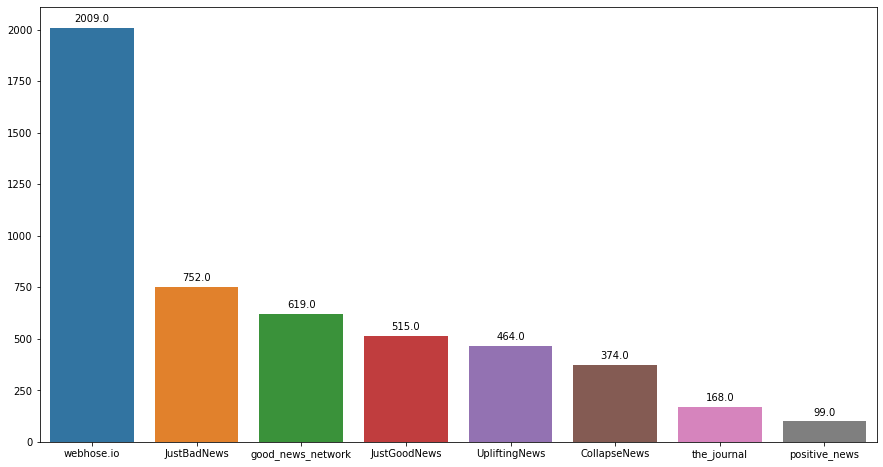

In [4]:
# Plot the source distribution
fig, ax = plt.subplots(figsize= (15,8))
ax = sns.barplot(x=df.source.value_counts().index, y=df.source.value_counts().values)
for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

#### Original News Sites
Let's first look at the different source domains in this dataset (original news site where the article was first posted to).

In [5]:
# Count unknown article source and drop them
url_list = df.url_short
print(f'The source domain is unknown for {df.url_short.isnull().sum()} articles')
url_list = url_list.dropna();

The source domain is unknown for 2009 articles


In [6]:
# Count the number of times the domain appears
values, counts = np.unique(url_list, return_counts=True)
df_url = {'url' : values, 'count' : counts}
df_url = pd.DataFrame(data=df_url)

# Sort by counts
df_url_sorted = df_url.sort_values('count', ascending=False)

# Print result
print(df_url.sort_values('count', ascending=False)[0:10])
print('--------')
print(f'There are at least {df_url.url.nunique()} unique domains in this dataset')

                 url  count
212  goodnewsnetwork    619
47               bbc    177
529       thejournal    149
522      theguardian    144
101              cnn     99
409         positive     99
431          reuters     87
242      independent     77
350          nbcnews     38
380          nytimes     35
--------
There are at least 637 unique domains in this dataset


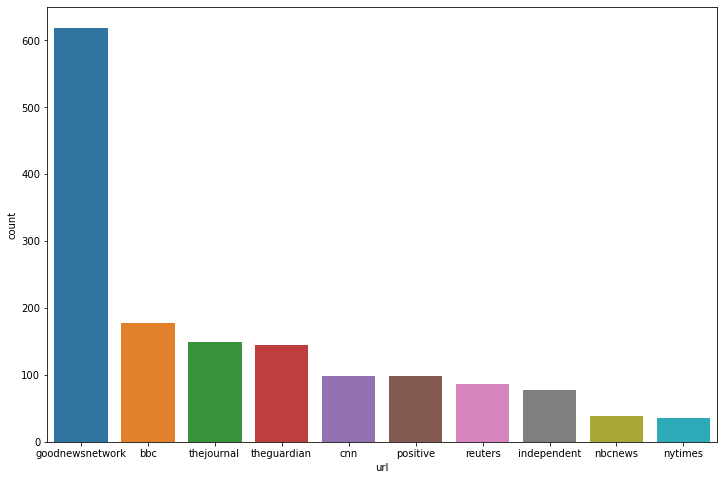

In [7]:
# Show top 10 domains
dims = (12, 8)
fig, ax = plt.subplots(figsize=dims)
ax = sns.barplot(x="url", y="count", data=df_url_sorted[0:10])

***
'goodnewsnetwork' is one of the scraped websites for positive news. In contrast to other similar sites, they write all of their articles and don't link to external sources. 
Thus it was expected that they would be one of the most frequent sites to find in our dataset.
'Positive' and 'thejournal' are also scraped sites for positive news, where they write some articles themselves.
***

In [8]:
# Drop specifically scraped sites
df_url_sorted = df_url_sorted.drop(df_url_sorted[df_url_sorted.url == 'goodnewsnetwork'].index)
df_url_sorted = df_url_sorted.drop(df_url_sorted[df_url_sorted.url == 'positive'].index)
df_url_sorted = df_url_sorted.drop(df_url_sorted[df_url_sorted.url == 'thejournal'].index)

The top 10 domains contribute at least 752 articles to the dataset


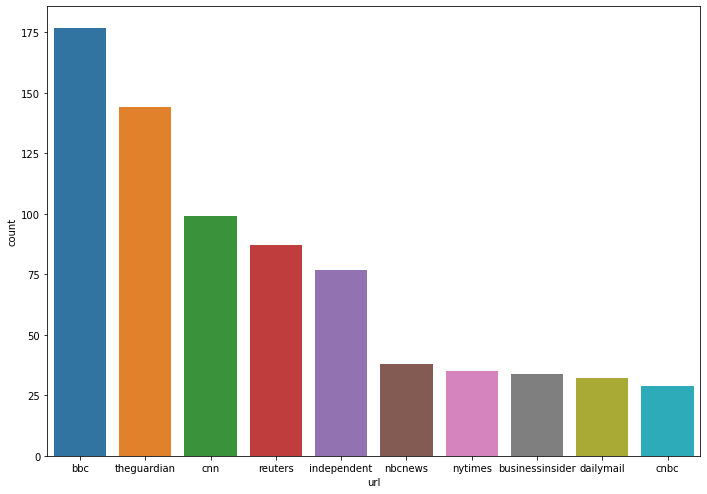

In [9]:
# Show top 10 again
dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
ax = sns.barplot(x="url", y="count", data=df_url_sorted[0:10])
print(f'The top 10 domains contribute at least {df_url_sorted["count"][0:10].sum()} articles to the dataset')

#### Word influence on good and bad/neutral news
Next up we will analyse the word distribution

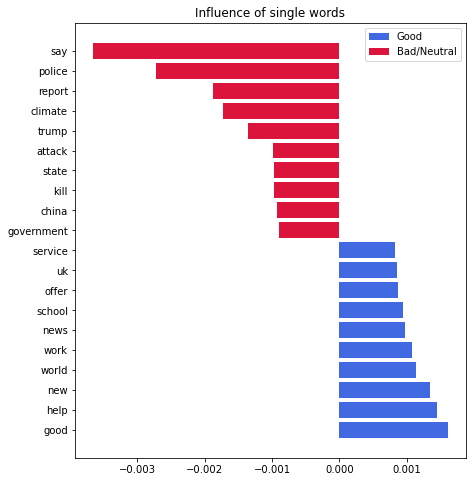

In [10]:
# Import libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize words by their number of appearance
vect = CountVectorizer()
X = vect.fit_transform(df.text_lem)
words = vect.get_feature_names()

# Define label
y = df['label'].values

# Remove alpha to prevent bias
clf = MultinomialNB(alpha=1.e-10)
clf.fit(X,y)

# Create Dataframe for probability
likelihood_df = pd.DataFrame(clf.feature_log_prob_.transpose(),columns=['negative', 'positive'], index=words)
likelihood_df['Influence'] = likelihood_df.eval('(exp(positive) - exp(negative))')
top_10 = likelihood_df['Influence'].sort_values(ascending=False)[:10]

# Double-sorting here so that the graph will look nicer
bottom_10 = likelihood_df['Influence'].sort_values()[:10].sort_values(ascending=False)
top_and_bottom = pd.concat([top_10,bottom_10])

# Plot
x = range(10)
fig = plt.figure(figsize=(7,8))
ax = plt.subplot(111)
ax.barh(top_10.index, top_10, color='royalblue')
ax.barh(bottom_10.index, bottom_10, color='crimson');
ax.set_title('Influence of single words');
ax.legend(['Good', 'Bad/Neutral']);

***
The influence of bad/neutral words seems to be greater than that of good words. Also the word 'say' seems to appear a lot more in bad/neutral labeled articles than in good ones, which is kind of interesting.
Most of the words make quite a bit of sense. 
'com' in the good category 

***

## Models

In [152]:
# Importing the auxiliary and preprocessing libraries 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# Import Models
import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Set random_state
random_state = 69

In [253]:
# Best parameters from Grid-RandomizedSearch
def best_parameters(model_name):
    print('---------------')
    print('Best parameters')
    print('---------------')
    for pair in model_name.best_params_.items():
        print(f'{pair[0].capitalize()} : {pair[1]}')

In [189]:
# Create models
models = []
models.append(("LogReg", LogisticRegression(n_jobs=-1, random_state=random_state)))  
models.append(("SGD_log", SGDClassifier(random_state=random_state, n_jobs=-1, loss='log')))
models.append(("NaiveBayes", MultinomialNB()))
models.append(("XGB", XGBClassifier(n_jobs=-1, random_state=random_state)))
models.append(("RandomForest", RandomForestClassifier(n_jobs=-1, random_state=random_state)))
models.append(("ExtraTrees", ExtraTreesClassifier(n_jobs=-1, random_state=random_state)))
models.append(("Ridge", RidgeClassifier(random_state=random_state)))
models.append(("BaggingRidge", BaggingClassifier(n_jobs=-1, random_state=random_state)))
models.append(("LinearSVC", LinearSVC(random_state=random_state)))
models.append(("SGD_hinge", SGDClassifier(random_state=random_state, n_jobs=-1, loss='hinge')))

In [358]:
# Split into train, test and validation dataframe
df_train, df_test = train_test_split(df, test_size=.2, random_state = random_state)
df_train, df_val = train_test_split(df_train, test_size=.2, random_state = random_state)

# Define train test and validation sets
X_train, y_train  = df_train['text_lem'], df_train['label']
X_test, y_test = df_test['text_lem'], df_test['label']
X_val, y_val = df_val['text_lem'], df_val['label']

In [484]:
#Get values from the group and categories
x_label = np.sort(df_train.source.unique())
y_train = df_train.source.value_counts().sort_index()
y_test = df_test.source.value_counts().sort_index()
y_val = df_val.source.value_counts().sort_index()

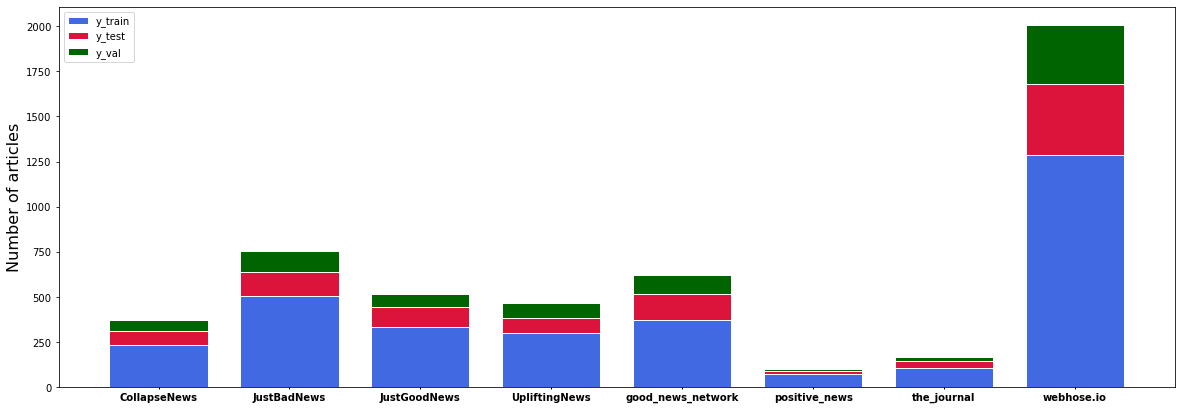

In [511]:
#add colors
# The position of the bars on the x-axis
r = range(len(quarter))
barWidth = .75

#plot bars
plt.figure(figsize=(20,7))
ax1 = plt.bar(r, y_train, color='royalblue', edgecolor='white', width=barWidth, label="y_train")
ax2 = plt.bar(r, y_test, bottom=np.array(y_train), color='crimson', edgecolor='white', width=barWidth, label='y_test')
ax3 = plt.bar(r, y_val, bottom=np.array(y_train)+np.array(y_test), color='darkgreen', edgecolor='white', width=barWidth, label='y_val')
plt.legend()
# Custom X axis
plt.xticks(r, x_label, fontweight='bold')
plt.ylabel("Number of articles", Fontsize=16)
plt.show()

In [359]:
# Sample weights for training since sources are very imbalanced
source_weight = 1/df_train.source.value_counts()*df_train.source.value_counts()[0]
sample_weight = [source_weight[i] for i in df_train.source]
source_weight

webhose.io            1.000000
JustBadNews           2.542574
good_news_network     3.442359
JustGoodNews          3.844311
UpliftingNews         4.308725
CollapseNews          5.534483
the_journal          12.346154
positive_news        18.342857
Name: source, dtype: float64

In [360]:
# Vectorize the data
tfidf = TfidfVectorizer()

# Fit the transformer
tfidf_fit = tfidf.fit(X_train)

# Transform all splits
X_train_tfidf = tfidf_fit.transform(X_train)
X_test_tfidf = tfidf_fit.transform(X_test)
X_val_tfidf = tfidf_fit.transform(X_val)

# Save the fitted transformer
pickle.dump(tfidf_fit, open("tfidf.pickle", "wb"))

In [361]:
# Print shapes of the splits
print(f'Shape train: {X_train.shape[0]} rows')
print(f'Shape test: {X_test.shape[0]} rows')
print(f'Shape val: {X_val.shape[0]} rows')

Shape train: 3200 rows
Shape test: 1000 rows
Shape val: 800 rows


In [365]:
model_results = pd.DataFrame(columns=['name', 'train', 'test', 'runtime'])

# Run the models, save and display results
for name, model  in models:
    
    # Start
    start = time()
    
    # Fit the model
    cv_results = model.fit(X_train_tfidf, y_train, sample_weight=sample_weight)
    
    # Score the model on train and test
    train_res = (model.score(X_train_tfidf, y_train)*100).round(2)
    test_res = (model.score(X_test_tfidf, y_test)*100).round(2)

    # End
    end = time()
    runtime = end-start
    
    # Save results
    results_df = pd.DataFrame([[name, train_res, test_res, runtime]], columns=['name', 'train', 'test', 'runtime'])
    model_results = model_results.append(results_df)
    
# Show results
model_results.set_index(pd.Index(list(range(0, model_results.shape[0]))), inplace=True)
model_results

,name,train,test,runtime
0,LogReg,94.09,84.2,1.108232
1,SGD_log,98.91,86.6,0.025863
2,NaiveBayes,84.44,73.0,0.012899
3,XGBC,85.91,78.8,10.310801
4,RandomForest,99.78,83.9,2.238943
5,ExtraTrees,99.78,85.0,3.465608
6,Ridge,98.16,81.3,0.082683
7,BaggingRidge,98.78,78.1,8.418127
8,LinearSVC,99.69,85.5,0.495483
9,SGD_hinge,99.66,84.1,0.033764


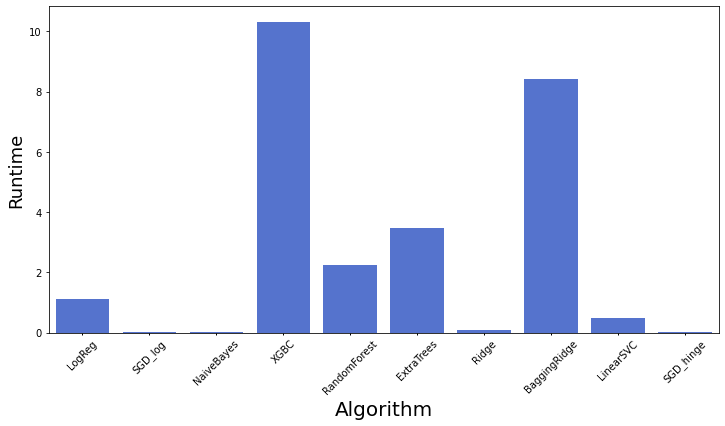

In [366]:
# Let's plot the runtime
fig = plt.figure(figsize=(12,6))
ax = sns.barplot(x="name", y="runtime", data=model_results, color='royalblue')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);
ax.set_xlabel("Algorithm", fontsize=20);
ax.set_ylabel("Runtime", fontsize=18)
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True

### Optimization

Let's use the best models and try to optimize them for the votingclassifier later.

In [367]:
# Sort models based on test results
model_results.sort_values(by=['test'], ascending=False)

,name,train,test,runtime
1,SGD_log,98.91,86.6,0.025863
8,LinearSVC,99.69,85.5,0.495483
5,ExtraTrees,99.78,85.0,3.465608
0,LogReg,94.09,84.2,1.108232
9,SGD_hinge,99.66,84.1,0.033764
4,RandomForest,99.78,83.9,2.238943
6,Ridge,98.16,81.3,0.082683
3,XGBC,85.91,78.8,10.310801
7,BaggingRidge,98.78,78.1,8.418127
2,NaiveBayes,84.44,73.0,0.012899


***
WHICH ONES AND WHY
***

#### Linear SupportVectorClassifier
The above results already show that the SVC is overfitting on the train set. This needs to be fixed for a better generalization later on.

In [217]:
# Try different C values 
C_sv = np.arange(0.025, 0.4, 0.025)
sv_results = pd.DataFrame(columns=['C', 'train', 'test', 'runtime'])
for c in C_sv:
    start = time()
    sv = LinearSVC(random_state=random_state, C=c)
    sv.fit(X_train_tfidf, y_train, sample_weight=sample_weight)
    end = time()
    runtime = end-start
    
    train_res = (sv.score(X_train_tfidf, y_train)*100).round(2)
    test_res = (sv.score(X_test_tfidf, y_test)*100).round(2)
    
    # Save results
    results_df = pd.DataFrame([[c, train_res, test_res, runtime]], columns=['C', 'train', 'test', 'runtime'])
    sv_results = sv_results.append(results_df)
    
sv_results.set_index(pd.Index(list(range(0, sv_results.shape[0]))), inplace=True)

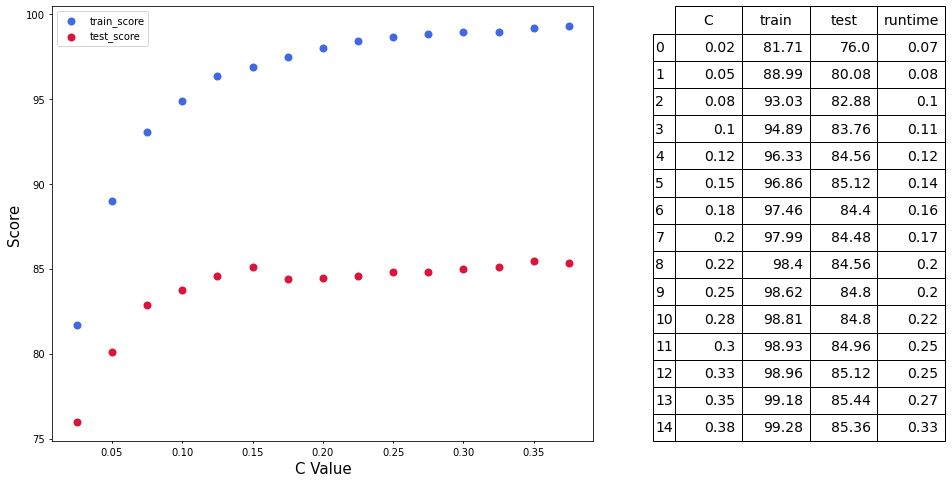

In [228]:
# Plot results
fig = plt.figure(constrained_layout=False, figsize=(16,8))
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[2, 1])

ax1 = fig.add_subplot(spec[0])
ax1.scatter(sv_results.C, sv_results.train, label='train_score', color='royalblue', linewidth=2)
ax1.scatter(sv_results.C, sv_results.test, label='test_score', color='crimson', linewidth=2)
plt.xlabel('C Value', Fontsize=15)
plt.ylabel('Score', Fontsize=15)
plt.legend();

ax2 = fig.add_subplot(spec[1])
font_size=14
bbox=[0, 0, 1, 1]
ax2.axis('off')
mpl_table = ax2.table(cellText = sv_results.values.round(2), rowLabels = sv_results.index, bbox=bbox, colLabels=sv_results.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

***
At C = 0.15 the test score lies at ~85%, while the train score is at ~97%. 
***

In [194]:
# Create best model and fit
sv_best = LinearSVC(random_state=random_state, C=0.15)
sv_best.fit(X_train_tfidf, y_train, sample_weight=sample_weight)

LinearSVC(C=0.15, random_state=69)

#### Logistic Regression

The default algorithm is already quite good. We can take a look at what happens when we introduce a few different C-Scores.

In [250]:
# Try different C values
C_lr = np.arange(0.1, 2, 0.1)
lr_results = pd.DataFrame(columns=['C', 'train', 'test', 'runtime'])
for c in C_lr:
    start = time()
    lr = LogisticRegression(random_state=random_state, C=c)
    lr.fit(X_train_tfidf, y_train, sample_weight=sample_weight)
    end = time()
    runtime = end-start
    
    train_res = (lr.score(X_train_tfidf, y_train)*100).round(2)
    test_res = (lr.score(X_test_tfidf, y_test)*100).round(2)
    
    # Save results
    results_df = pd.DataFrame([[c, train_res, test_res, runtime]], columns=['C', 'train', 'test', 'runtime'])
    lr_results = lr_results.append(results_df)
    
lr_results.set_index(pd.Index(list(range(0, lr_results.shape[0]))), inplace=True)

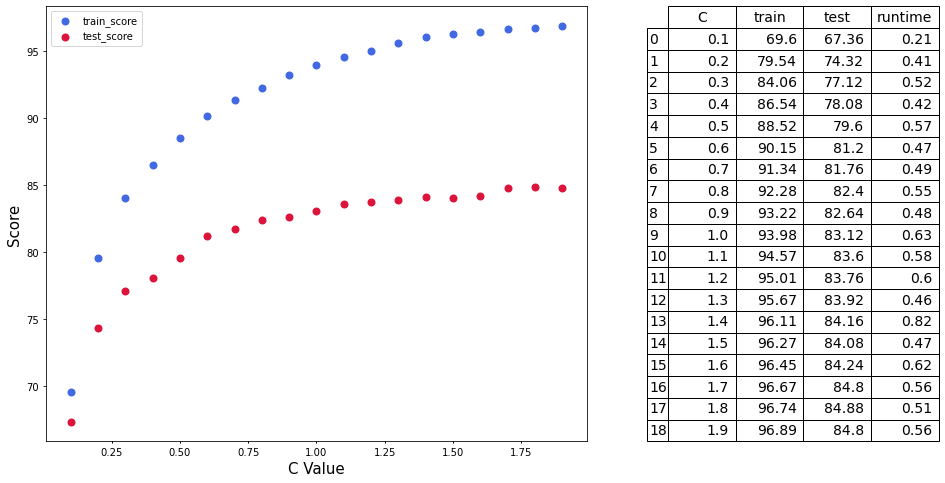

In [251]:
# Plot results
fig = plt.figure(constrained_layout=False, figsize=(16,8))
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[2, 1])

ax1 = fig.add_subplot(spec[0])
ax1.scatter(lr_results.C, lr_results.train, label='train_score', color='royalblue', linewidth=2)
ax1.scatter(lr_results.C, lr_results.test, label='test_score', color='crimson', linewidth=2)
plt.xlabel('C Value', Fontsize=15)
plt.ylabel('Score', Fontsize=15)
plt.legend();

ax2 = fig.add_subplot(spec[1])
font_size=14
bbox=[0, 0, 1, 1]
ax2.axis('off')
mpl_table = ax2.table(cellText = lr_results.values.round(2), rowLabels = lr_results.index, bbox=bbox, colLabels=lr_results.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

In [252]:
# Create best model and fit
lr_best = LinearSVC(random_state=random_state, C=1.2)
lr_best.fit(X_train_tfidf, y_train, sample_weight=sample_weight)

LinearSVC(C=1.2, random_state=69)

#### Extra-trees classifier

In [305]:
# Define parameters for RandomizedSearch
et = ExtraTreesClassifier(n_jobs=-1, random_state=random_state, max_depth=67, min_samples_split=5, bootstrap=False,
                         criterion='gini', min_samples_leaf=1)
et.fit(X_train_tfidf, y_train, sample_weight=sample_weight)
print((et.score(X_train_tfidf, y_train)*100).round(2))
print((et.score(X_test_tfidf, y_test)*100).round(2))

94.85
80.16


In [309]:
params_et = {'max_depth' : np.linspace(10, 200, num = 11).tolist() + [None],
            'min_samples_split' : [5, 10, 15, 20, 25, 30, 50],
            'min_samples_leaf' : [1,2,3,4,5],
            'bootstrap' : [True, False],
            'max_leaf_nodes' : [50, 100, 150, 200, 500],
            'criterion' : ['gini', 'entropy']
            }

# Run GridSearch
et_search = RandomizedSearchCV(et, params_et, cv=3, n_jobs=-1, verbose=1, n_iter = 100, random_state=random_state)
et_search.fit(X_train_tfidf, y_train, sample_weight=sample_weight)

# Print the best parameters
best_parameters(et_search)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.3min finished


---------------
Best parameters
---------------
Min_samples_split : 15
Min_samples_leaf : 1
Max_leaf_nodes : 500
Max_depth : 162.0
Criterion : entropy
Bootstrap : True


In [333]:
# Get best model
et_best = ExtraTreesClassifier(n_jobs=-1, random_state=random_state, max_depth=110, min_samples_split=15, bootstrap=True,
                         criterion='entropy', min_samples_leaf=1, max_leaf_nodes=500)
# Fit on the data
et_best.fit(X_train_tfidf, y_train, sample_weight=sample_weight)

# Print results
print(f"Accuracy for train set : {(et_best.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(et_best.score(X_test_tfidf, y_test)*100).round(2)}%")

Accuracy for train set : 96.33%
Accuracy for test set : 82.56%


#### Voting Classifier

In [449]:
vc = VotingClassifier(estimators=[('sv', sv_best), ('lr', lr_best), ('et', et_best)], voting='hard')
vc.fit(X_train_tfidf, y_train, sample_weight=sample_weight)
y_pred = vc.predict(X_val_tfidf)
pickle.dump(vc, open("vc.pickle", "wb"))

In [450]:
print(f"Accuracy for train set : {(vc.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(vc.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(vc.score(X_val_tfidf, y_val)*100).round(2)}%")

Accuracy for train set : 98.75%
Accuracy for test set : 86.1%
Accuracy for val set: 86.88%


In [451]:
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_pred, y_val))

[[338  67]
 [ 38 357]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       376
           1       0.90      0.84      0.87       424

    accuracy                           0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.87      0.87      0.87       800



### Incorrect predictions
Let's find out where our model is wrong and maybe we can figure out why.

In [384]:
# Create a list of all incorrectly predicted articles
incorrect_pred = []
correct_pred = []
idx = 0
for vect, prediction, label in zip(X_val_tfidf, y_pred, y_val):
    if prediction != label:
        incorrect_pred.append(X_val.index[idx])
    else:
        correct_pred.append(X_val.index[idx])
    idx += 1

In [385]:
# Create dataframes for wrong and correct predictions
df_incorrect_predictions = df[df.index.isin(incorrect_pred)]
df_correct_predictions = df[df.index.isin(correct_pred)]

In [423]:
# Filter out the source, where our model is wrong and right
source_series = pd.Series(data=0, index=df.source.value_counts().index).sort_index()
source_incorrect = df_incorrect_predictions.source.value_counts().sort_index()
source_incorrect = source_series.combine(source_incorrect,max)
source_correct = df_correct_predictions.source.value_counts().sort_index()
source_correct = source_series.combine(source_correct,max)
source_all = (source_incorrect + source_correct).sort_index()

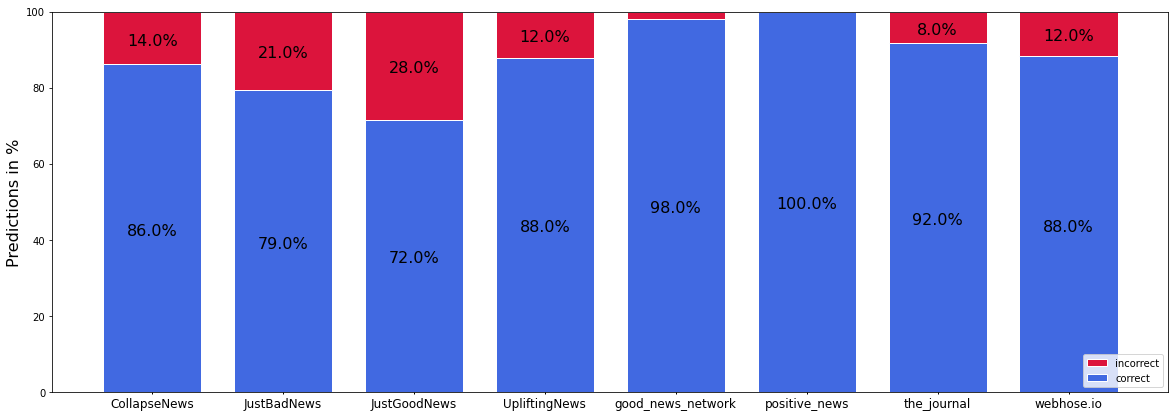

In [448]:
# Plot predictions for different sources in percent

# Get prediction values
x = source_all.index
y_incorrect = source_incorrect.values
y_correct = source_correct.values
total = y_incorrect + y_correct
proportion_incorrect = np.true_divide(y_incorrect, total) * 100
proportion_correct = np.true_divide(y_correct, total) * 100
    
# Chose colors
colors = ['crimson', 'royalblue']

# The position of the bars on the x-axis
r = range(len(x))
barWidth = 0.75

# Plot
fig, ax = plt.subplots(figsize=(20,7))
rects1 = ax.bar(r, proportion_incorrect, bottom=proportion_correct, color=colors[0], edgecolor='white', width=barWidth, label="incorrect")
rects2 = ax.bar(r, proportion_correct, color=colors[1], edgecolor='white', width=barWidth, label='correct')

height = []
for rect in rects2:
    height.append(rect.get_height())

i = 0
for rect in rects2:
    ax.annotate(str(height[i].round()) + '%',
                xy=(rect.get_x() + rect.get_width() / 2, height[i] / 2),
                xytext=(0, -10),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                Fontsize=16)
    ax.annotate((str(100 - height[i].round()) + '%') if height[i] < 97 else ' ',
                xy=(rect.get_x() + rect.get_width() / 2, height[i] + (100 - height[i])/2),
                xytext=(0, -10), 
                textcoords="offset points",
                ha='center', va='bottom',
                Fontsize=16)
    i += 1
    
plt.legend(loc=4)
plt.xticks(r, x, Fontsize=12)
plt.ylabel("Predictions in %", Fontsize=16)
plt.savefig("predictions_stacked.png")
plt.show()